# Sunny Side Sketch Challenge Problem

<img src="https://i.ibb.co/MknQ67tW/eggs.png" width="100%" style="max-width: 600px; display:block; margin:auto;">


Once upon a time, an ambitious engineer was tasked with inventing an “egg-maker” — a marvelous machine that could whip up eggs in all their delicious forms: fried, scrambled, poached, you name it. But somewhere along the way, wires got crossed (literally), and instead of producing eggs, the machine started… drawing them. Perfectly neat outlines of every egg recipe you could imagine appeared on paper, but not a single breakfast was served.
And so, the legend of the “Egg-Maker-That-Only-Makes-Egg-DRAWINGS” was born.

Your task: Design 2D planar linkage mechanisms that can trace six target egg-paths. These curves are your recipes — now go cook up some mechanisms!



We have given you the outlines of eggs we want in a numpy file called `target_curves.npy` which you can load using numpy and plot using matplotlib:

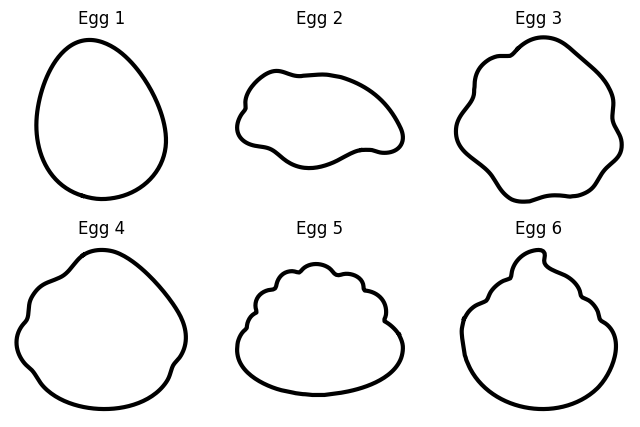

In [217]:
import numpy as np
import matplotlib.pyplot as plt

target_curves = np.load('target_curves.npy')

# Plot all target curves

# Initialize a 2x3 subplot for plotting all target curves
fig, axs = plt.subplots(2, 3, figsize=(8, 5))

# Loop through the 6 target curves to plot them
for i in range(6):
    # Extract x and y coordinates from the target curve
    x_coords = np.array(target_curves[i])[:, 0]
    y_coords = np.array(target_curves[i])[:, 1]

    # Plot the curve on the respective subplot
    axs[i // 3, i % 3].plot(x_coords, y_coords, color='black', linewidth=3)

    # Set title for each subplot
    axs[i // 3, i % 3].set_title(f'Egg {i + 1}')

    # Ensure equal scaling for x and y axes
    axs[i // 3, i % 3].axis('equal')
    axs[i // 3, i % 3].axis('off')

## Mechanism Representation

Here we will briefly discuss how we can represent linkage mechanisms. In this demonstration we will represent linkage mechanisms as graphs. A graph is represented as a set of nodes (e.g., $N = \{1,2,3,\ldots,N\}$), and set of edges, that describe how nodes are connected to each other (e.g., $E=\{(1,2), (5,2), \ldots \}$). Graphs can also include features associated with each node (e.g., initial positions of joints in our example of mechanisms).

To see how this works take the mechanism below:

<div width="100%"><img src="https://i.ibb.co/qsPC0gC/2021-09-13-0hl-Kleki.png" alt="Path Synthesis Problem" width="40%" style="margin:auto;display:block"></div>


We can see that we have 5 joints, which we will represent as 5 nodes, $N=\{0,1,2,3,4\}$, and we can represent the linkages as edges in the graph, which give us the edges $E=\{(0,2),(1,3),(2,3),(2,4),(3,4)\}$. Note that edges in this graph do not have directions so $(0,2)$ and $(2,0)$ are identical. To keep things neat so we put the smaller index first. Besides the basic graph describing the mechanisms structure, we also see that all nodes have an initial position in 2D space. Nodes $0$ and $1$ are fixed and will remain in place, while the others will move. We will describe these as node features. This means each node will have a 2D initial position and a binary feature describing whether it is fixed or not. We can also see that one of the linkages is highlighed yellow. This is the linkage that is rotated by the actuator. We will also store this information.

In practice the above description boils down to a few (Design) variables in python which we use to describe the mechanism:

- **Initial Positions** `x0`: A 2D array of size $N \times 2$, holding the initial positions of the $N$ joints in the mechanism.
- **Linkages** `edges`: A 2D array of ***integer*** pairs, with shape $E \times 2$ holding the pairs of node indecies from two nodes that are connected to each other by an edge.
- **Fixed Joints** `fixed_joints`: A list of node indices that are fixed.
- **Motor** `motor`: A tuple of integers, which is equivalent to the pair of node indices associated with the actuated edge.

This representation is fine, however sometimes instead of explicitly specifying edges a different approach is used to describe graph connectivity. The so called <b>Adjacency/Connectivity Matrix</b> is another way to represent the edges of a graph. A linkage mechanisms structure can therefore be represented using a matrix of connectivity ($C$), which is similar to the adjacency matrix in graphs (networks). The connectivity matrix for a mechanisms with $N$ nodes is a symmetric $N\times N$ matrix with each row and column representing each node and its connections to other nodes. Take the example below:

<img src="https://transportgeography.org/wp-content/uploads/simple_connectivity_matrix2.png" width="100%" style="max-width: 700px; display:block; margin:auto;" alt="Connectivity Matrix">

For Node A we use the first row/column of the matrix and we see that A is connected to B (which is represented by the second row/column). To represent this connection in the connectivity matrix we will set the value of the $(1,2)$ and $(2,1)$ elements of the matrix to be 1. Similarly any time any nodes $i$ and $j$ are connected with an edge we set the value of the $(i,j)$ and $(j,i)$ elements to be 1 and 0 if the nodes are not connected. We will use this kind of representation in the advanced starter notebook to show how this can help us define a problem for GA that generates the structure of the mechanism as well.

## Instructions


[IMPORTANT] In this project three constraints are set for you:
<ul>
    <li><b>Distance: </b>Any mechanisms output with a distance to the target curve larger than 0.75 will be considered invalid and will not be used to calculate the score of the submissions.</li>
    <li><b>Material Use: </b>Any mechanism with total linkage lengths more than 10.0 will be deemed invalid and will not be used to calculate the score of the submissions.</li>
    <li><b>Mechanism Complexity: </b>For this project we want you to generate mechanisms with no more than 20 joints </li>
</ul>

Submitted mechanisms that violate these constraints will not be scored.

Your performance on the targets will be measured based on the hypervolume calculated from the population with a reference point of 0.75 for distance and 10.0 for material use. Note that we limit the number of mechanisms you are permitted to submit as potential solutions for any given curve to 1000. The closer you get to ideal the higher the score you will receive. The total score for your submission will be the average hypervolume for all target curves.

## GTA Submission
Now we will run the GA for each target curve seperately and get a full submission going:

In [218]:
import os
# os.environ["JAX_PLATFORMS"] = "cpu"  # Disable GPU for JAX (Remove if you want to use GPU)

import numpy as np
import matplotlib.pyplot as plt
import random

# deteministic random numbers
np.random.seed(0)
random.seed(0)

from LINKS.CP import make_empty_submission, evaluate_submission
from LINKS.Kinematics import MechanismSolver
from LINKS.Optimization import DifferentiableTools, Tools
from LINKS.Geometry import CurveEngine
from LINKS.Visualization import MechanismVisualizer, GAVisualizer

# pymoo imports
from pymoo.core.problem import ElementwiseProblem, Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize
from pymoo.indicators.hv import HV


In [219]:
PROBLEM_TOOLS = Tools( # we have to define this outside the class due to pymoo deepcopy limitations
            device='cpu' # device to run the optimization on
        )  
PROBLEM_TOOLS.compile() # compile the functions for faster runs

class mechanism_Synthesis_optimization(ElementwiseProblem):

    # When intializing get the mechanism structure which is being optimized
    #(not the initial positions as we are trying to find those)
    def __init__(self, edges, fixed_joints, motor, target_curve):

        # set the problem paramters(n_var = number of parameters(number of nodes * 2),
        # n_obj=number of objectives, xl=lower bound for the parameters, xu=upper bound for the paramters)
        super().__init__(n_var = x0.shape[0] * 2, n_obj=2, n_constr=2, xl=0.0, xu=5.0, elementwise_evaluation=True)

        # Store mechanism information for later
        self.edges = edges
        self.fixed_joints = fixed_joints
        self.motor = motor
        self.N = x0.shape[0]

        # Store the target
        self.target_curve = target_curve
        
    def _evaluate(self, x, out, *args, **kwargs):
        x0 = np.array(x.reshape([self.N,2]))  #reshape the flattened vector that comes in into 2D array
        
        # Simulate
        distance, material = PROBLEM_TOOLS(x0,
                                self.edges,
                                self.fixed_joints,
                                self.motor,
                                self.target_curve,
                                target_idx=None # if you do not specify a target node index, it will automatically use the most complex joint (the last joint in our case)
                            )

        out["F"] = np.array([distance, material])
        out["G"] = out["F"] - np.array([0.75, 10.0])  # Constraints: distance <= 0.75, material <= 10.0

In [220]:
target_curves = np.load('target_curves.npy')

solver = MechanismSolver(
    device = 'cpu' # device to run the simulation on (cpu or gpu)
)

curve_processor = CurveEngine(
    normalize_scale=False, # do not normalize the scale of the curve (This would mean we care about the size of the curve too!)
    device='cpu'
)

optimization_tools = Tools(
    device='cpu' # device to run the optimization on
)
optimization_tools.compile() # compile the functions for faster runs

gradient_tools = DifferentiableTools(
    device='cpu' # device to run the optimization on
)
gradient_tools.compile() # compile the functions for faster runs

In [221]:
# starter_mech = np.load('starter_mechanism.npy',allow_pickle=True).item() #Load mechanism

# x0 = starter_mech['x0']
# edges = starter_mech['edges']
# fixed_joints = starter_mech['fixed_joints']
# motor = starter_mech['motor']


x0 = np.array([[0.3,0.2],
               [0.6,0.2],
               [0.3,0.3],
               [0.6,0.4],
               [0.4,0.5]])

edges = np.array([[0,2],
                  [1,3],
                  [2,3],
                  [2,4],
                  [3,4]])

fixed_joints = np.array([0,1])
motor = np.array([0,2])

In [222]:
# visualizer = MechanismVisualizer()
# plt.figure(figsize=(5,5))
# visualizer(x0, edges, fixed_joints, motor, ax=plt.gca())

In [223]:
population_size = 500
num_generations = 100
curves_to_run = [0, 1, 2, 3, 4, 5]

Optimizing for Problem 1, Please Wait...
Distance to target curve 1: 0.1010
Material used: 2.5824
Distance Gradient:
 [array([-2.5284157,  2.6991527], dtype=float32), array([0.03704228, 0.23172197], dtype=float32), array([2.5092843 , 0.43010187], dtype=float32), array([0.0404821 , 0.21785551], dtype=float32), array([-0.05839121, -3.578833  ], dtype=float32)]

Material Gradient:
 [array([-1.2851944,  1.5324084], dtype=float32), array([ 1.9949635 , -0.14184688], dtype=float32), array([ 2.7334867, -5.1550055], dtype=float32), array([-4.4368134,  3.3023977], dtype=float32), array([0.99355745, 0.46204662], dtype=float32)]

Optimizing for Problem 2, Please Wait...
Distance to target curve 2: 0.9436
Material used: 2.0654
Distance Gradient:
 [array([-8.558924 , -6.7879333], dtype=float32), array([5.0743427, 3.9898322], dtype=float32), array([10.784889 , -2.6432648], dtype=float32), array([-10.905065 ,  -6.4086695], dtype=float32), array([ 3.6047554, 11.850039 ], dtype=float32)]

Material Gradi

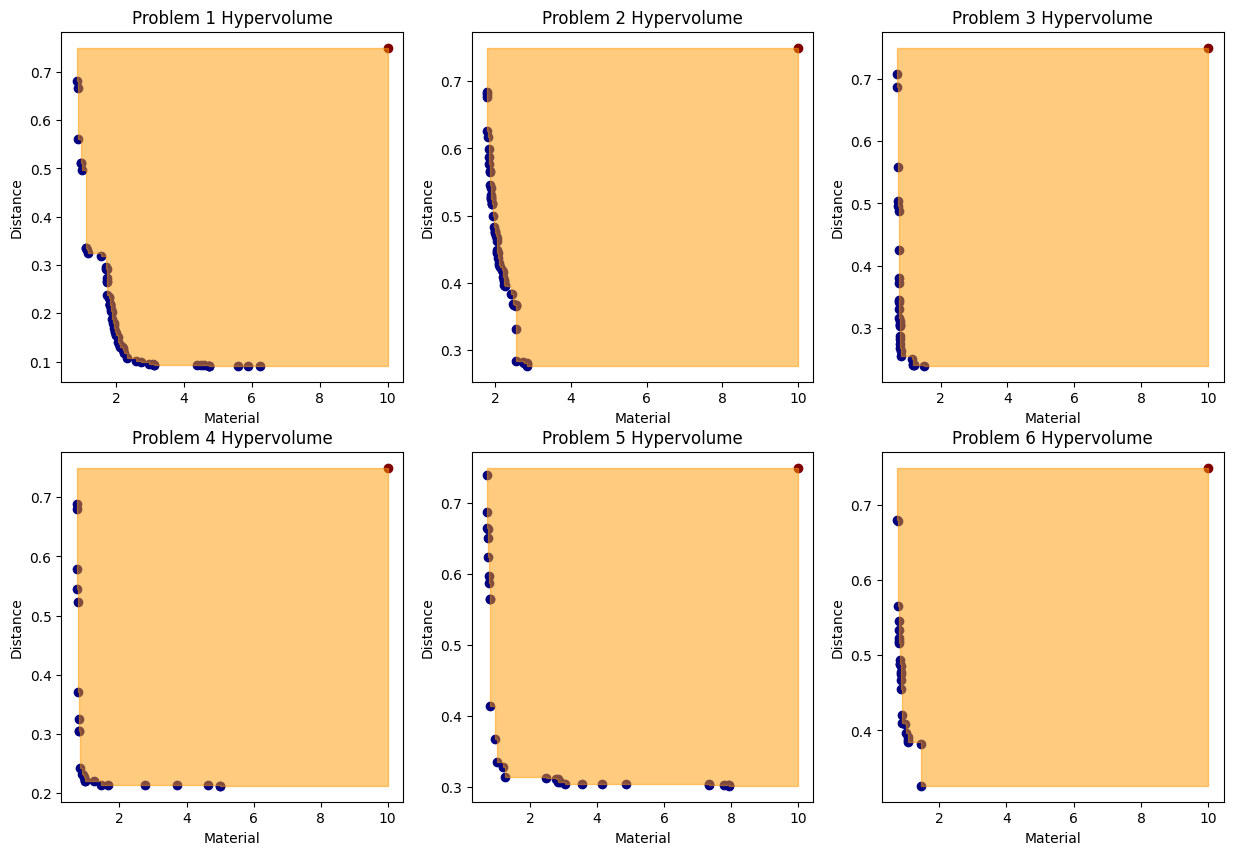

In [ ]:
submission = make_empty_submission()
full_results = submission.copy()

for i in curves_to_run:
    
    print(f"Optimizing for Problem {i+1}, Please Wait...")
    
    problem = mechanism_Synthesis_optimization(
        edges,
        fixed_joints,
        motor,
        target_curves[i]
    )
    
    X = x0[None].repeat(population_size, axis=0).reshape(population_size, -1)
    # Setup the algorithm
    algorithm = NSGA2(pop_size=population_size,
                        sampling=X,
                        crossover=SBX(prob=1.0, eta=3.0),
                        mutation=PolynomialMutation(eta=3.0, prob=0.9),
                        eliminate_duplicates=True)

    results = minimize(problem,
                    algorithm,
                    ('n_gen', num_generations),
                    verbose=False,
                    save_history=True,
                    seed=123,
                    )
    
    if results.X is None:
        print('Did Not Find Solutions!!')
    else:
        for j in range(results.X.shape[0]):
            x0_member = results.X[j].reshape(-1,2)
            
            mech = {
                'x0': x0_member,
                'edges': edges,
                'fixed_joints': fixed_joints,
                'motor': motor,
                'target_joint': None # None means it will automatically use the most complex joint (the last joint in our case)
            }

            submission[f'Problem {i+1}'].append(mech)
            full_results[f'Problem {i+1}'] = results
        
        distance, material, distance_grad, material_grad = gradient_tools(x0_member,
                                        edges,
                                        fixed_joints,
                                        motor,
                                        target_curves[0],
                                        target_idx=None # if you do not specify a target node index, it will automatically use the most complex joint (the last joint in our case)
                                    )
        print(f"Distance to target curve {i+1}: {distance:.4f}")
        print(f"Material used: {material:.4f}")
        print(f"Distance Gradient:\n {distance_grad}\n")
        print(f"Material Gradient:\n {material_grad}\n")


# now let's evaluate the pareto efficient solutions for all problems
ga_visualizer = GAVisualizer()
plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(target_curves)):
    if isinstance(full_results[f'Problem {i+1}'], list) or full_results[f'Problem {i+1}'].X is None:
        print(f'Did Not Find Solutions for Problem {i+1}!!')
        plt.subplot(2, 3, i+1)
        plt.text(0.5, 0.5, 'No Solutions Found', horizontalalignment='center', verticalalignment='center', fontsize=12)
        plt.axis('off')
        continue
    ga_visualizer.plot_HV(
        F=full_results[f'Problem {i+1}'].F,
        ref=np.array([0.75, 10.0]),
        ax=plt.subplot(2, 3, i+1),
        objective_labels=['Distance', 'Material']
    )
    plt.title(f'Problem {i+1} Hypervolume')

In [225]:
scores = evaluate_submission(submission)

overall_score = scores.get('Overall Score', 0)
problem_scores = [scores['Score Breakdown'].get(f'Problem {i+1}', 0) for i in range(len(scores['Score Breakdown']))]

print(f"Overall Score: {overall_score:.3f}")
print(f"Per Problem Scores: {problem_scores}")

best_submission = np.load('GTA_full_submission.npy', allow_pickle=True).item()
best_scores = evaluate_submission(best_submission)

# Compare and update the best scores if necessary
for i, (current_score, best_score) in enumerate(zip(problem_scores, best_scores['Score Breakdown'].values())):
    if current_score > best_score:
        best_submission[f'Problem {i+1}'] = submission[f'Problem {i+1}']
        print(f"Problem {i} improved! Was: {best_score}")

submission_filename = 'GTA_full_submission.npy'
best_submission['Overall Score'] = np.mean(list(evaluate_submission(best_submission)['Score Breakdown'].values()))
np.save(submission_filename, best_submission)


best_scores = evaluate_submission(best_submission)
b_overall_score = best_scores.get('Overall Score', 0)
b_problem_scores = [best_scores['Score Breakdown'].get(f'Problem {i+1}', 0) for i in range(len(best_scores['Score Breakdown']))]

print(f"Best Overall Score: {b_overall_score:.3f}")
print(f"Best Per Problem Scores: {b_problem_scores}")

Overall Score: 4.512
Per Problem Scores: [5.711237023963232, 3.7580908677527987, 4.719342835128515, 4.950677577389672, 4.078914303284899, 3.8532109239265875]
Best Overall Score: 4.522
Best Per Problem Scores: [5.711237023963232, 3.7580908677527987, 4.719342835128515, 5.01041226447558, 4.078914303284899, 3.8532109239265875]


## Leader Board:
You can submit your numpy files to the leaderboard and see how you are doing compared to others. 
The leaderboard can be found at:

[https://design-ai.mit.edu/CP1/](https://design-ai.mit.edu/CP1/)